# Inversion karyotypes for *Phase2*

Identify **2La inversion** status in Phase2 samples by comparing PCA of genotypes with that of karyotyped Phase1 data.

In [1]:
# output
chrom    = "2L"
outdir   = "karyotype_2La_output"
kary_fn  = "data/samples_p1.karyotype.txt"
kary_inv = "kt_2la"
outcode  = "phase2_2La"
popc     = "population"

# inversion 2La
inv_start = 20524058 # interval 20524058 - 20528089
inv_end   = 42165532 # interval 42165182 - 42165532

# input data phase2
p2_metasam_fn  = "data/samples_p2.meta.txt"
p2_callset_fn  = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/haplotypes/zarr2/ag1000g.phase2.ar1.samples/"  #### EDIT THIS 
p2_accessi_fn  = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/accessibility/accessibility.h5"                #### EDIT THIS
# define populations phase2
p2_popl        = ["AOcol","BFcol","BFgam","CIcol","CMgam","FRgam","GAgam","GHcol","GHgam","GM","GNcol","GNgam","GQgam","GW","KE","UGgam"]

# input data phase1
p1_metasam_fn  = "data/samples_p1.meta.txt"
p1_callset_fn  = "/home/xavi/dades/Variation/phase1.AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.%s.h5"   #### EDIT THIS
p1_accessi_fn  = "/home/xavi/dades/Variation/phase1.AR3/accessibility/accessibility.h5"                             #### EDIT THIS
# define populations phase1
p1_popl        = ["AOM","BFM","BFS","CMS","GAS","GNS","GWA","KES","UGS"]

Libraries:

In [2]:
%%capture
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import zarr
import pandas as pd
import allel
import h5py

Other settings:

In [3]:
# load plot settings
sns.set(context="notebook",style="ticks",
        font_scale=1.3,rc={"lines.linewidth": 1},
        font="Arial",palette="bright")

def annotate_barplot(ax,color="k", labformat = "{:.2f}"):
    rects = ax.patches
    for rect in rects:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        space   = 5
        ha      = 'left'
        label   = labformat.format(x_value) ## annotates bars with height labels, with 2 decimal points
        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", va='center', ha=ha, color=color)


## Load data

### Samples

Load data for all variants & genotypes. Population and sample structure:

In [4]:
# load samples list with sample code, groupings, locations etc.
p2_samples_df   = pd.read_csv(p2_metasam_fn, sep='\t')
p2_samples_bool = (p2_samples_df[popc].isin(p2_popl).values)
p2_samples_sub  = p2_samples_df[p2_samples_bool]
p2_samples_sub.reset_index(drop=True, inplace=True)

# indexed dictionary of populations
p2_popdict = dict()
for popi in p2_popl: 
    p2_popdict[popi]  = p2_samples_sub[p2_samples_sub[popc] == popi].index.tolist()

# add an extra population composed of all other locations
p2_popdict["all"] = []
for popi in p2_popl:
    p2_popdict["all"] = p2_popdict["all"] + p2_popdict[popi]


# report
print("Data:")
print("* Samples     = ", p2_samples_sub.shape[0])
print("* Populations = ", set(p2_samples_sub[popc]))
print(p2_samples_sub.groupby(("population")).size())

Data:
* Samples     =  1142
* Populations =  {'GQgam', 'GM', 'GW', 'GNcol', 'KE', 'BFgam', 'UGgam', 'AOcol', 'FRgam', 'GHgam', 'GHcol', 'CIcol', 'BFcol', 'GAgam', 'CMgam', 'GNgam'}
population
AOcol     78
BFcol     75
BFgam     92
CIcol     71
CMgam    297
FRgam     24
GAgam     69
GHcol     55
GHgam     12
GM        65
GNcol      4
GNgam     40
GQgam      9
GW        91
KE        48
UGgam    112
dtype: int64


In [5]:
# load samples list with sample code, groupings, locations etc.
p1_samples_df   = pd.read_csv(p1_metasam_fn, sep='\t')
p1_samples_bool = (p1_samples_df[popc].isin(p1_popl).values)
p1_samples_sub  = p1_samples_df[p1_samples_bool]
p1_samples_sub.reset_index(drop=True, inplace=True)

# indexed dictionary of populations
p1_popdict = dict()
for popi in p1_popl: 
    p1_popdict[popi]  = p1_samples_sub[p1_samples_sub[popc] == popi].index.tolist()

# add an extra population composed of all other locations
p1_popdict["all"] = []
for popi in p1_popl:
    p1_popdict["all"] = p1_popdict["all"] + p1_popdict[popi]

# report
print("Data:")
print("* Samples     = ", p1_samples_sub.shape[0])
print("* Populations = ", set(p1_samples_sub[popc]))
print(p1_samples_sub.groupby(("population")).size())

Data:
* Samples     =  765
* Populations =  {'BFM', 'GNS', 'AOM', 'UGS', 'BFS', 'CMS', 'GWA', 'KES', 'GAS'}
population
AOM     60
BFM     69
BFS     81
CMS    275
GAS     56
GNS     31
GWA     46
KES     44
UGS    103
dtype: int64


### Variants and genotypes

In [6]:
# declare objects with variant data
p2_callset   = zarr.open(p2_callset_fn)
    
# variants of genotypes
print("Variants...")
p2_callset_var = p2_callset[chrom]["variants"]
p2_genvars = allel.VariantChunkedTable(p2_callset_var,names=["POS","REF","ALT"],index="POS") # variants
pos_bool   = np.logical_and(p2_genvars["POS"][:] >= inv_start, p2_genvars["POS"][:] <= inv_end)
p2_genvars = p2_genvars.compress(pos_bool)

# genotype data
print("Genotypes...")
p2_callset_gen = p2_callset[chrom]["calldata"]["genotype"]
p2_genotyp     = allel.GenotypeChunkedArray(p2_callset_gen) # genotypes
p2_genotyp_sub = p2_genotyp.subset(sel0=pos_bool, sel1=p2_samples_bool)
# allele counts
print("Allele counts...")
p2_genalco_sep = p2_genotyp_sub.count_alleles_subpops(subpops=p2_popdict)

# report
print(p2_genalco_sep.shape)

Variants...
Genotypes...
Allele counts...
(3710136,)


In [7]:
# declare objects with variant data
p1_callset   = h5py.File(p1_callset_fn % chrom,mode="r")
    
# variants of genotypes
print("Variants...")
p1_callset_var = p1_callset[chrom]["variants"]
p1_genvars = allel.VariantChunkedTable(p1_callset_var,names=["POS","REF","ALT"],index="POS") # variants
pos_bool   = np.logical_and(p1_genvars["POS"][:] >= inv_start, p1_genvars["POS"][:] <= inv_end)
p1_genvars = p1_genvars.compress(pos_bool)

# genotype data
print("Genotypes...")
p1_callset_gen = p1_callset[chrom]["calldata"]["genotype"]
p1_genotyp     = allel.GenotypeChunkedArray(p1_callset_gen) # genotypes
p1_genotyp_sub = p1_genotyp.subset(sel0=pos_bool, sel1=p1_samples_bool)
# allele counts
print("Allele counts...")
p1_genalco_sep = p1_genotyp_sub.count_alleles_subpops(subpops=p1_popdict)

# report
print(p1_genalco_sep.shape)

Variants...
Genotypes...
Allele counts...
(3474151,)


### Filters

Filter phase2, phase1 and arabiensis:

In [8]:
# subset data: segregating alleles, biallelic and no singletons
print("Filters p2...")
p2_is_seg      = p2_genalco_sep["all"].is_segregating()[:] # segregating
p2_is_nosing   = p2_genalco_sep["all"][:,:2].min(axis=1)>2 # no singletons

# subset phase2 to seg, nosing, biallelic & outgroup size
p2_genotyp_seg = p2_genotyp_sub.compress((p2_is_seg[:] & p2_is_nosing[:]))
p2_genvars_seg = p2_genvars.compress((p2_is_seg[:] & p2_is_nosing[:]))
p2_genalco_seg = p2_genalco_sep.compress((p2_is_seg[:] & p2_is_nosing[:]))

# report
print(p2_genotyp_seg.shape,"/", p2_genotyp_sub.shape)

Filters p2...
(2006430, 1142, 2) / (3710136, 1142, 2)


In [9]:
# subset data: segregating alleles, biallelic and no singletons
print("Filters p1...")
p1_is_seg      = p1_genalco_sep["all"].is_segregating()[:] # segregating
p1_is_nosing   = p1_genalco_sep["all"][:,:2].min(axis=1)>2 # no singletons

# subset phase2 to seg, nosing, biallelic & outgroup size
p1_genotyp_seg = p1_genotyp_sub.compress((p1_is_seg[:] & p1_is_nosing[:]))
p1_genvars_seg = p1_genvars.compress((p1_is_seg[:] & p1_is_nosing[:]))
p1_genalco_seg = p1_genalco_sep.compress((p1_is_seg[:] & p1_is_nosing[:]))

# report
print(p1_genotyp_seg.shape,"/", p1_genotyp_sub.shape)

Filters p1...
(1736143, 765, 2) / (3474151, 765, 2)


Subset p1 and p2:

In [10]:
# is p2 in p1?
is_p2_in_p1 = np.isin(p2_genvars_seg["POS"][:],test_elements=p1_genvars_seg["POS"][:])
# subset phase2 to fit phase1
print("Subset phase2...")
p2_genotyp_seg = p2_genotyp_seg.compress((is_p2_in_p1))
p2_genvars_seg = p2_genvars_seg.compress((is_p2_in_p1))
p2_genalco_seg = p2_genalco_seg.compress((is_p2_in_p1))

# is p1 in p2?
is_p1_in_p2 = np.isin(p1_genvars_seg["POS"][:],test_elements=p2_genvars_seg["POS"][:])
# subset phase1 to fit phase2
print("Subset phase1...")
p1_genotyp_seg = p1_genotyp_seg.compress((is_p1_in_p2))
p1_genvars_seg = p1_genvars_seg.compress((is_p1_in_p2))
p1_genalco_seg = p1_genalco_seg.compress((is_p1_in_p2))

# report
print(p2_genalco_seg.shape,p1_genalco_seg.shape)

Subset phase2...
Subset phase1...
(1594426,) (1594426,)


## Karyotype table

Available for Phase1 data alone:

In [11]:
kary_df = pd.read_csv(kary_fn, sep='\t')
kary_df_sub  = kary_df[p1_samples_bool]
kary_df_sub.reset_index(drop=True, inplace=True)
kary_df_sub[kary_inv].shape

(765,)

## PCA

Create joint genotype counts phase1+2:

In [12]:
is_p2_in_p1 = np.isin(p2_samples_df["ox_code"].values, p1_samples_df["ox_code"].values) # exclude samples from p2 that are also in p1
is_p2_no_p1 = np.invert(is_p2_in_p1)

In [13]:
genotyp_n = np.hstack(
    (p2_genotyp_seg.subset(sel1=is_p2_no_p1).to_n_alt()[:],
     p1_genotyp_seg.to_n_alt()[:]))
print(genotyp_n.shape)

(1594426, 1142)


In [14]:
# mock inversion genotypes for phase2 and arabiensis
p2_samples_sub["inv"] = "unk"

In [15]:
random_ix = np.random.randint(genotyp_n.shape[1], size=10000)
pca_coo, pca_mod = allel.stats.randomized_pca(genotyp_n[random_ix],scaler="patterson")

Dataframe with PCs:

In [16]:
p2_samples_sub[is_p2_no_p1]["inv"].values.shape

(377,)

In [17]:
kary_df_sub[kary_inv].values.shape

(765,)

In [18]:
pca_df = pd.DataFrame(data={
    "inv" : np.concatenate((p2_samples_sub[is_p2_no_p1]["inv"].values,kary_df_sub[kary_inv].values)),
    1 : pca_coo[:,1-1] , 
    2 : pca_coo[:,2-1] ,
    3 : pca_coo[:,3-1] ,
    4 : pca_coo[:,4-1] ,
    5 : pca_coo[:,5-1] ,
    6 : pca_coo[:,6-1] ,
    7 : pca_coo[:,7-1] ,
    8 : pca_coo[:,8-1] ,
    9 : pca_coo[:,9-1] ,
    10: pca_coo[:,10-1] ,
})

Variance explained per PC:

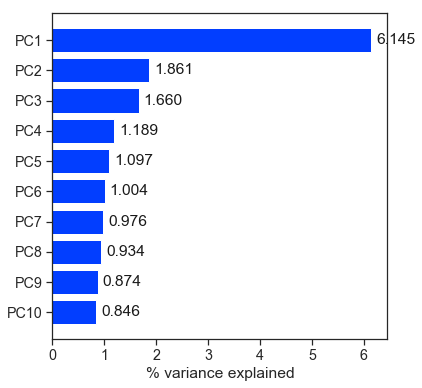

In [19]:
pdf_pages = PdfPages("%s/%s.%s.pdf" % (outdir,outcode,"explained_variance"))
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)

labels = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"]
plt.barh(y=labels[::-1],width=pca_mod.explained_variance_ratio_[::-1]*100)
annotate_barplot(ax=ax, labformat="{:.3f}")
ax.set_xlabel("% variance explained")

pdf_pages.savefig(fig,bbox_inches='tight')
pdf_pages.close()

Plot PCs:

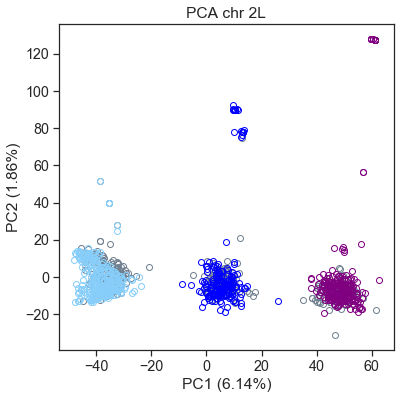

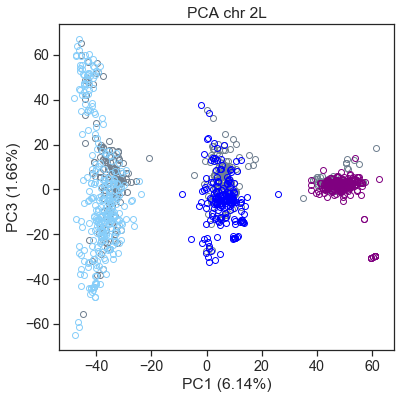

In [20]:
pdf_pages = PdfPages("%s/%s.%s.pdf" % (outdir,outcode,"PCA"))

for pci in [1]:
    for pcj in [1,2,3]:
        if pci < pcj:
            
            fig = plt.figure(figsize=(6,6))
            
            for pca_df_ix, pca_df_rw in pca_df.iterrows():
                if pca_df_rw["inv"] == "unk" : plt.plot(pca_df_rw[pci], pca_df_rw[pcj], "o", color='slategray', mfc='none')
                if pca_df_rw["inv"] == 0     : plt.plot(pca_df_rw[pci], pca_df_rw[pcj], "o", color='lightskyblue', mfc='none')
                if pca_df_rw["inv"] == 1     : plt.plot(pca_df_rw[pci], pca_df_rw[pcj], "o", color='blue', mfc='none')
                if pca_df_rw["inv"] == 2     : plt.plot(pca_df_rw[pci], pca_df_rw[pcj], "o", color='purple', mfc='none')

            plt.title("PCA chr %s" % chrom)
            plt.xlabel('PC%i (%.2f%%)' % (pci,pca_mod.explained_variance_ratio_[pci-1]*100))
            plt.ylabel('PC%i (%.2f%%)' % (pcj,pca_mod.explained_variance_ratio_[pcj-1]*100))

            pdf_pages.savefig(fig,bbox_inches='tight')
    
pdf_pages.close()

## Supervised learning

SVC (C-Support Vector Classification), a type of SVM (support vector machine). See https://scikit-learn.org/stable/modules/svm.html#

In [21]:
import sklearn
from sklearn import tree
from sklearn import model_selection
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import graphviz

Create test and train data with individuals from phase 1 (i.e. those for which inversion is not `NA`):

In [22]:
# variables from phase 1 + classification, to train classifiers
phase1_vars = pca_df[[1,2,3,4,5,6,7,8,9,10]][np.logical_and(pca_df["inv"] != "unk", pca_df["inv"] != "ara")]
phase1_clas = pca_df["inv"][np.logical_and(pca_df["inv"] != "unk", pca_df["inv"] != "ara")].astype(str)

# variables from phase 2 that will need to be predicted
phase2_vars = pca_df[[1,2,3,4,5,6,7,8,9,10]][pca_df["inv"] == "unk"]


print("phase1 train dataset",phase1_vars.shape)
print("phase2 dataset to predict",phase2_vars.shape)

phase1 train dataset (765, 10)
phase2 dataset to predict (377, 10)


### Train SVC

Support vector classifier (SVC):


In [23]:
# create classifier
clf_svc = sklearn.svm.SVC(kernel='linear', C=1).fit(phase1_vars, phase1_clas)

### Measure accuracy

Accuracy from Phase1 data:

In [24]:
# accuracy from test data
clf_svc_score = clf_svc.score(phase1_vars, phase1_clas)
print("Accuracy = %0.4f" % clf_svc_score)

Accuracy = 1.0000


Precision and recall from Phase1 data:

In [25]:
print(classification_report(phase1_clas, clf_svc.predict(phase1_vars)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       324
           1       1.00      1.00      1.00       195
           2       1.00      1.00      1.00       246

   micro avg       1.00      1.00      1.00       765
   macro avg       1.00      1.00      1.00       765
weighted avg       1.00      1.00      1.00       765



Confusion matrix with phase1 data:

In [26]:
print(confusion_matrix(phase1_clas, clf_svc.predict(phase1_vars)))

[[324   0   0]
 [  0 195   0]
 [  0   0 246]]


### Predict Phase 2 karyotypes

Using SVC:

In [27]:
phase1_kt_estimated = clf_svc.predict(phase1_vars)
phase2_kt_estimated = clf_svc.predict(phase2_vars)

Save results:

In [28]:
p2_samples_sub["inv_estimated"]                  = -1
p2_samples_sub.loc[is_p2_in_p1, "inv_estimated"] = phase1_kt_estimated
p2_samples_sub.loc[is_p2_no_p1, "inv_estimated"] = phase2_kt_estimated
np.unique(p2_samples_sub["inv_estimated"], return_counts=True)

(array(['0', '1', '2'], dtype=object), array([479, 334, 329]))

In [29]:
out_df = pd.DataFrame(data={
    "ox_code"      : np.concatenate((p2_samples_sub["ox_code"].values,p1_samples_sub["ox_code"].values)),
    "population"   : np.concatenate((p2_samples_sub["population"].values,p1_samples_sub["population"].values)),
    "real_kt"      : np.concatenate((p2_samples_sub["inv"].values,kary_df_sub[kary_inv].values)),
    "estimated_kt" : np.concatenate((p2_samples_sub["inv_estimated"].values,phase1_kt_estimated)),
})

out_df[["ox_code","population","real_kt","estimated_kt"]].to_csv("%s/%s.karyotype.csv" % (outdir,outcode), sep="\t",index=False)